In [2]:
from keras.preprocessing.image import ImageDataGenerator

data_directory = "C:\\Users\\ASUS\\Proyek_Tekcertan\\dataset\\web_scraped"

image_height = 256
image_width = 256
BATCH_SIZE = 32

# Definisikan ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    # tambahkan augmentasi lainnya jika diperlukan
)

# Flow data dalam batch menggunakan generator
data_generator = datagen.flow_from_directory(
    data_directory,
    target_size=(image_height, image_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 48764 images belonging to 8 classes.


In [3]:
import os
from PIL import Image

def validate_images_and_remove_invalid(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # Memastikan file gambar valid
            except (IOError, SyntaxError) as e:
                print(f'Invalid image: {file_path} - {e}')
                os.remove(file_path)  # Menghapus file tidak valid
                print(f'{file_path} removed.')

# Tentukan lokasi dataset Anda
directory_to_check = "dataset/web_scraped"

# Jalankan validasi dan hapus file tidak valid
validate_images_and_remove_invalid(directory_to_check)


In [4]:
# Library setup  
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# Keras library 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau

# Different CNN Model
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, MobileNetV2, DenseNet121

# To chain two different data augmented images for training
from itertools import chain

# Classification metrics
from sklearn.metrics import roc_curve, auc

# Filter the UserWarnings related to TensorFlow I/O
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_io")

#  Distributed Computing
import tensorflow as tf

In [5]:
# Parameter Setup
BATCH_SIZE = 32

image_height = 256
image_width = 256

In [6]:
# Image Augmentation
# Data agumentation and pre-processing using tensorflow
data_generator_1 = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            brightness_range = [0.9,1.1],
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest'                                   
                        )

print('Data Augmentation 1 was created')

data_generator_2 = ImageDataGenerator (rescale=1./255)

print('Original images was used for testing')

Data Augmentation 1 was created
Original images was used for testing


In [7]:
# Read the image
train_generator = data_generator_1.flow_from_directory(
    directory = "dataset/data_training", # images data path / folder in which images are there
#     subset = 'training',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 1234)

val_generator = data_generator_2.flow_from_directory(
    directory = "dataset/data_validasi", # images data path / folder in which images are there
#     subset = 'validation',
    color_mode = "rgb",
    target_size = (image_height, image_width), # image height , image width
    class_mode = "categorical",
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = 1234)

Found 39007 images belonging to 8 classes.
Found 9757 images belonging to 8 classes.


In [8]:
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))
class_names = list(dict_class.keys())
print('Class labels: {}'.format(class_names))

Dictionary: {'cushion': 0, 'emerald': 1, 'heart': 2, 'marquise': 3, 'oval': 4, 'pear': 5, 'princess': 6, 'round': 7}
Class labels: ['cushion', 'emerald', 'heart', 'marquise', 'oval', 'pear', 'princess', 'round']


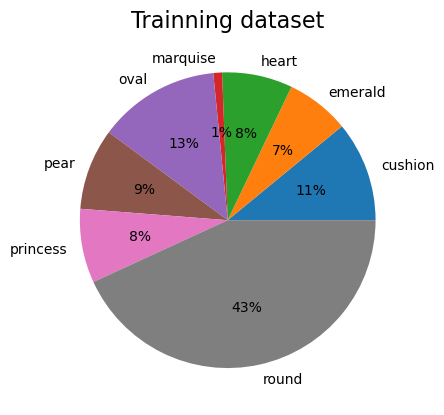

In [9]:
frequency = np.unique(train_generator.classes, return_counts=True)

plt.title("Trainning dataset", fontsize='16')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%');


Train image data from Data Augmentation 1


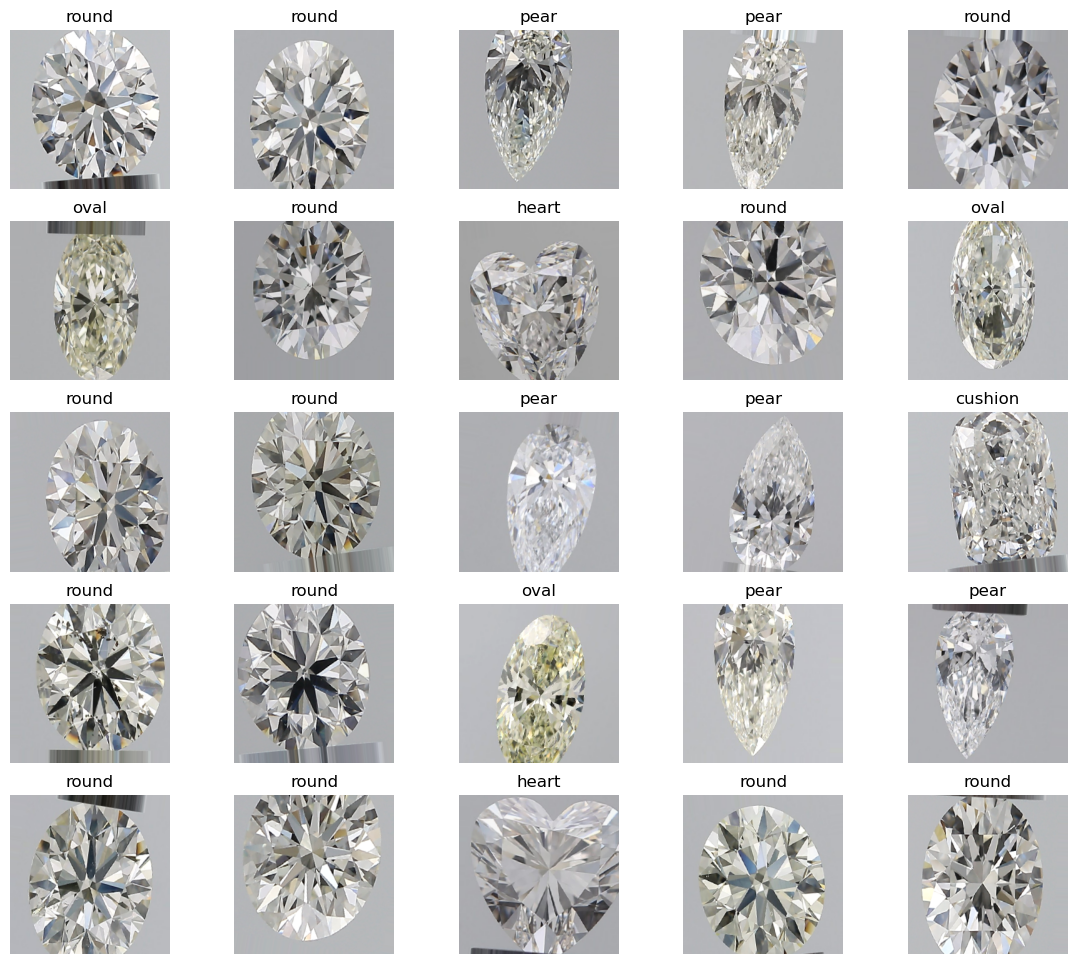

In [10]:
# Image Samples
print('Train image data from Data Augmentation 1')
img, label = next(train_generator)
# print(len(label))

plt.figure(figsize=[14, 12])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

In [12]:
# CNN Setup 
# Define the epochs for training 
EPOCHS = 2

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1, restore_best_weights=True)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.001, patience=10, verbose=1)

In [13]:
1# Load the pre-trained MobileNetV2 model without the top classification layer
base_model_MobileNet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

# Set the layers of the base model as non-trainable (freeze them)
for layer in base_model_MobileNet.layers:
    layer.trainable = False

# Create a new model and add the MobileNetV2 base model
model_MobileNet = Sequential()
model_MobileNet.add(base_model_MobileNet)

# Add a global average pooling layer and output layer for classification
# model_MobileNet.add(GlobalAveragePooling2D())
# model_MobileNet.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model_MobileNet.add(Dropout(0.4))
# model_MobileNet.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
# model_MobileNet.add(Dropout(0.2))
# model_MobileNet.add(Dense(5, activation='softmax'))


# For Code Testing
model_MobileNet.add(GlobalAveragePooling2D())
model_MobileNet.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_MobileNet.add(Dropout(0.2))
model_MobileNet.add(Dense(8, activation='softmax'))

# Model summary
print("Model Summary (MobileNetV2):")
model_MobileNet.summary()
print()

# Compile the model
model_MobileNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_MobileNet = model_MobileNet.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping])

Model Summary (MobileNetV2):
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 2299240 (8.77

In [14]:
# Validate the model
print('====== Model Validation ======')
val_loss_MobileNet, val_accuracy_MobileNet = model_MobileNet.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_MobileNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_MobileNet:.4f}')     

====== Model Validation ======
305/305 [==============================] - 231s 753ms/step - loss: 0.0575 - accuracy: 0.9917
Validation Loss: 0.0575
Validation Accuracy: 0.9917


In [15]:
# Fine-tune the model with frozen layers

# Unfreeze the base_model
no_base_layers = len(base_model_MobileNet.layers)
print('No. of base layers in the model = {}\n'.format(no_base_layers))

# no of layers for fine-tune
no_finetune_layers = int(no_base_layers/4)
print('No. of layers for fine-tune = {}'.format(no_finetune_layers))

# history = fit_model(inception_model, inception_base_model, epochs = FINE_TUNING_EPOCHS, fine_tune = int(nr_base_layers/4))

No. of base layers in the model = 154

No. of layers for fine-tune = 38


In [16]:
# Fine-tune the model
base_model_MobileNet.trainable = True
for layer in base_model_MobileNet.layers[: -no_finetune_layers]:
    layer.trainable = False       

# small learning rate for fine tuning
model_MobileNet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune_MobileNet = model_MobileNet.fit(train_generator, epochs=EPOCHS, validation_data=val_generator, callbacks=[early_stopping])

Epoch 1/2
1219/1219 [==============================] - 2158s 2s/step - loss: 0.1465 - accuracy: 0.9662 - val_loss: 0.0523 - val_accuracy: 0.9939
Epoch 2/2
1219/1219 [==============================] - 2446s 2s/step - loss: 0.0582 - accuracy: 0.9935 - val_loss: 0.0477 - val_accuracy: 0.9953


In [17]:
# Validate the model
print('====== Model Validation ======')
val_loss_finetune_MobileNet, val_accuracy_finetune_MobileNet = model_MobileNet.evaluate(val_generator, steps=len(val_generator))
print(f'Validation Loss: {val_loss_finetune_MobileNet:.4f}')
print(f'Validation Accuracy: {val_accuracy_finetune_MobileNet:.4f}')

====== Model Validation ======
305/305 [==============================] - 199s 650ms/step - loss: 0.0477 - accuracy: 0.9953
Validation Loss: 0.0477
Validation Accuracy: 0.9953


In [18]:
# Perform predictions to allow computation of the confusion matrix later on
# Do not shuffle predictions otherwise we have no way of finding out the true labels
# val_generator.reset()
MobileNet_test_preds = model_MobileNet.predict(val_generator)
MobileNet_test_pred_classes = np.argmax(MobileNet_test_preds, axis=1)

305/305 [==============================] - 203s 660ms/step


1/1 [==============================] - 1s 1s/step


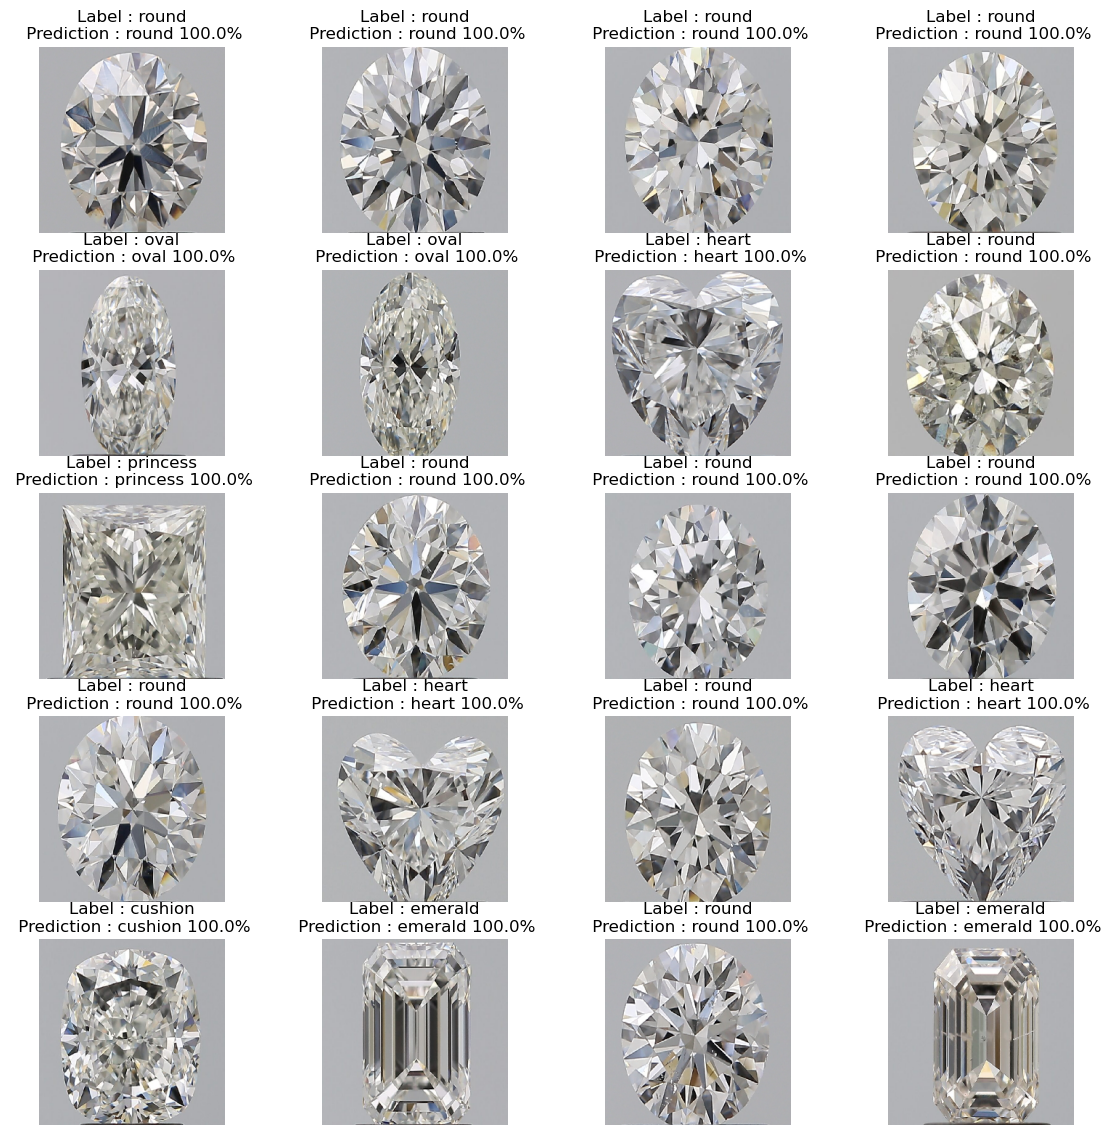

In [19]:
val_generator.reset()
img, label = next(val_generator)

prediction = model_MobileNet.predict(img)
test_pred_classes = np.argmax(prediction, axis=1)

plt.figure(figsize=[14, 14])
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title("Label : {}\n Prediction : {} {:.1f}%".format(class_names[np.argmax(label[i])], class_names[test_pred_classes[i]], 100 * np.max(prediction[i])))
plt.show()

1/1 [==============================] - 1s 799ms/step


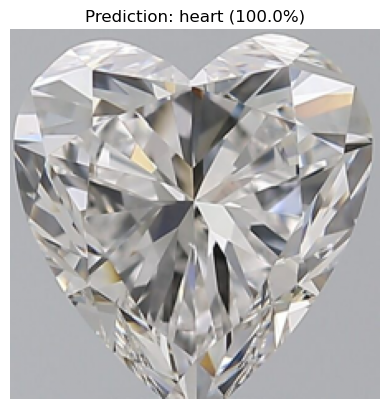

In [20]:
from PIL import Image

# Masukkan path gambar yang ingin Anda prediksi
image_path = 'dataset/data_testing/heart/220123-195.jpg'  # Ganti dengan path gambar Anda

# Membaca gambar menggunakan PIL
img = Image.open(image_path)
img = img.resize((224, 224))  # Sesuaikan ukuran gambar dengan yang digunakan oleh model

# Normalisasi gambar
img = np.array(img) / 255.0

# Menambahkan dimensi batch
img = np.expand_dims(img, axis=0)

# Melakukan prediksi pada gambar
prediction = model_MobileNet.predict(img)
pred_class = np.argmax(prediction)

# Menampilkan gambar dan hasil prediksi
plt.imshow(img[0])
plt.axis('off')
plt.title("Prediction: {} ({:.1f}%)".format(class_names[pred_class], 100 * np.max(prediction)))
plt.show()


In [21]:
model_MobileNet.save('modelku')

INFO:tensorflow:Assets written to: modelku\assets


INFO:tensorflow:Assets written to: modelku\assets
